Лог задачи:

Нейронка 

Градиентный бустинг

В сумме нейронка и бустинг дают 88.4% на локальном тесте.

# Общая часть

In [1]:
%pylab inline
import pandas as pd
pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Читаем входные файлы с данными

In [3]:
tr_types = pd.read_csv('tr_types.csv', sep = ';')
print(tr_types.shape)
tr_types.head()

(155, 2)


,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...


In [4]:
tr_mcc_codes = pd.read_csv('tr_mcc_codes.csv', sep = ';')
print(tr_mcc_codes.shape)
tr_mcc_codes.head()

(184, 2)


,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


In [5]:
transactions = pd.read_csv('transactions.csv', sep = ',')
print(transactions.shape)
transactions.head()

(6849346, 6)


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [6]:
customers_gender_train = pd.read_csv('customers_gender_train.csv', sep = ',')
print(customers_gender_train.shape)
customers_gender_train.head()

(12000, 2)


,customer_id,gender
0,75562265,0
1,10928546,1
2,69348468,1
3,84816985,1
4,61009479,0


In [34]:
customers_gender = customers_gender_train.set_index('customer_id')

In [8]:
transactions['time'] = transactions.tr_datetime.apply(lambda dt: dt.split()[1][0:2]).astype(int)

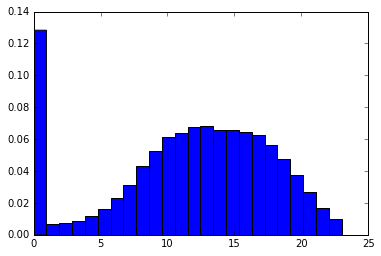

In [9]:
_ = hist(transactions['time'], normed = True, bins = 24)

In [10]:
time_count = transactions.groupby(['customer_id', 'time'])[['amount']].count().reset_index()
time_count = time_count.pivot(index='customer_id', columns='time', values='amount').fillna(0)
time_count.shape

(15000, 24)

In [11]:
transactions['abs_amount'] = transactions['amount'].abs()

### Бейзлайн

Для каждого клиента подсчитываем различные mcc_code

In [6]:
X = transactions.groupby('customer_id') \
                    .apply(lambda x: x[['mcc_code']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [8]:
customers_gender = customers_gender_train.set_index('customer_id')

In [9]:
Y_train = customers_gender.loc[X.index].gender
Y_train = Y_train.reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

In [10]:
X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')

Обучаемся на всех данных

In [13]:
clf = GradientBoostingClassifier(random_state=13)
clf.fit(X_train, Y_train.values[:, 0])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=13,
              subsample=1.0, verbose=0, warm_start=False)

Предсказываем пол для тестовых данных и создаём файл с ответом

In [14]:
X_test = X.drop(customers_gender.index)
result = pd.DataFrame(X_test.index, columns=['customer_id'])
result['gender'] = clf.predict_proba(X_test)[:, 1]

In [11]:
result.to_csv('baseline_a.csv', index=False)

### Создание признаков

In [12]:
mcc_count= transactions.groupby('customer_id').apply(lambda x: x[['mcc_code']].unstack().value_counts()).unstack().fillna(0)
mcc_count.shape

(15000, 184)

In [13]:
type_count= transactions.groupby('customer_id').apply(lambda x: x[['tr_type']].unstack().value_counts()).unstack().fillna(0)
type_count.shape

(15000, 77)

In [215]:
X = pd.concat([mcc_count, type_count], axis = 1)

Y_train = customers_gender.loc[X.index].gender
Y_train = Y_train.reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')

In [53]:
mcc_count.shape, type_count.shape, X_train.shape

((15000, 184), (15000, 77), (12000, 261))

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train.values[:, 0], test_size = 0.3, random_state = 42)

### Нейронка и ебустинг

В прошлый раз получил также 86.8% - всё честно.

In [46]:
nn2 = MLPClassifier(hidden_layer_sizes=(150,50,5), activation='relu', alpha=0.01, early_stopping=True, random_state = 42)
nn2.fit(log(1+x_train), y_train)
roc_auc_score(y_test,  nn2.predict_proba(log(1+x_test))[:,1])

0.86837265625000004

Логрегрессия почти так же классна, как нейросетушка!

In [176]:
lr = LogisticRegression(penalty= 'l2', C = 0.1, random_state = 42)
lr.fit(log(1+x_train), y_train)
roc_auc_score(y_test,  lr.predict_proba(log(1+x_test))[:,1])

0.86710734375000009

In [152]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 50, max_depth=5)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(log(1+x_train), y_train)
roc_auc_score(y_test,  gbc.predict_proba(log(1+x_test))[:,1])

0.86070281250000003

При склеивании получаю джини под 87.2%, как и собирался.

In [51]:
roc_auc_score(y_test,  nn2.predict_proba(log(1+x_test))[:,1]+gbc.predict_proba(log(1+x_test))[:,1])

0.87200828125000007

In [58]:
X_test = X.drop(customers_gender.index)
result = pd.DataFrame(X_test.index, columns=['customer_id'])
result['gender'] = nn2.predict_proba(log(1+X_test))[:, 1]*0.7 + gbc.predict_proba(log(1+X_test))[:, 1] * 0.3

In [60]:
print(result.shape)
result.head()

(3000, 2)


,customer_id,gender
0,49101,0.440015
1,114348,0.754649
2,127946,0.795105
3,137367,0.536945
4,174467,0.757122


In [61]:
result.to_csv('a06_2.csv', index=False)

Честный рекорд на тесте = 87.2%. Хотя на валидации это только 86.3%

### Смотрю на важные признаки

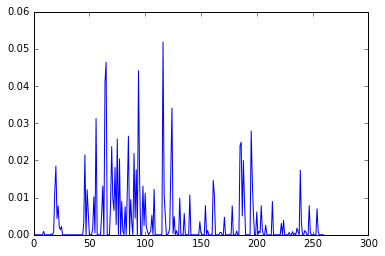

In [153]:
plot(gbc.feature_importances_)

In [173]:
important = x_train.columns[gbc.feature_importances_> 0.02]
print(important.tolist())
pd.merge(tr_mcc_codes, pd.DataFrame({'mcc_code':important.tolist()}))

[5211, 5411, 5533, 5541, 5621, 5661, 5691, 5732, 5812, 5912, 5977, 6011, 1010, 1030, 2010]


,mcc_code,mcc_description
0,5211,Лесо- и строительный материал
1,5411,"Бакалейные магазины, супермаркеты"
2,5533,Автозапчасти и аксессуары
3,5541,Станции техобслуживания
4,5621,Готовая женская одежда
5,5661,Обувные магазины
6,5691,Магазины мужской и женской одежды
7,5732,Продажа электронного оборудования
8,5812,"Места общественного питания, рестораны"
9,5912,Аптеки


In [174]:
pd.merge(tr_types, pd.DataFrame({'tr_type':important.tolist()}))

,tr_type,tr_description
0,1010,Покупка. POS ТУ СБ РФ
1,1030,Оплата услуги. Банкоматы СБ РФ
2,2010,Выдача наличных в АТМ Сбербанк России


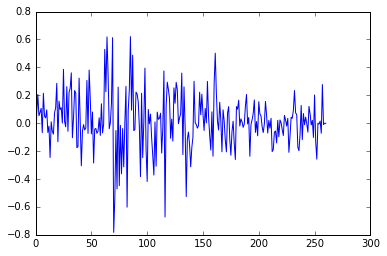

In [177]:
plot(lr.coef_[0])

Мужские транзакции:

In [179]:
pd.merge(tr_mcc_codes, pd.DataFrame({'mcc_code':x_train.columns[lr.coef_[0]> 0.4].tolist()}))

,mcc_code,mcc_description
0,5511,"Легковой и грузовой транспорт — продажа, серви..."
1,5533,Автозапчасти и аксессуары
2,5611,"Мужская одежда и аксессуары, включая одежду дл..."
3,5732,Продажа электронного оборудования
4,5734,Продажа компьютерного программного обеспечения
5,7994,Галереи/учреждения видеоигр


Женские транзакции

In [180]:
pd.merge(tr_mcc_codes, pd.DataFrame({'mcc_code':x_train.columns[lr.coef_[0]< -0.4].tolist()}))

,mcc_code,mcc_description
0,5621,Готовая женская одежда
1,5631,Аксессуары для женщин
2,5651,Одежда для всей семьи
3,5661,Обувные магазины
4,5714,"Ткани, обивочный материал, гардины и портьеры,..."
5,5943,"Магазины офисных, школьных принадлежностей, ка..."
6,5977,Магазины косметики
7,7230,Салоты красоты и парикмахерские


нейтральные транзакции

In [181]:
pd.merge(tr_mcc_codes, pd.DataFrame({'mcc_code':x_train.columns[abs(lr.coef_[0])< 0.01].tolist()}))

,mcc_code,mcc_description
0,4900,"Коммунальные услуги — электричество, газ, сани..."
1,5169,"Химикалии и смежные вещества, не классифициров..."
2,5499,"Различные продовольственные магазины — рынки, ..."
3,5571,Продажа мотоциклов
4,5712,"Оборудование, мебель и бытовые принадлежности ..."
5,5945,Магазины игрушек
6,5950,Магазины хрусталя и изделий из стекла
7,6300,"Продажа страхования, гарантированное размещени..."
8,7375,Информационные провайдеры
9,7395,"Фотостудии, фотолаборатории"


In [336]:
Y_train.head()

,gender
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0


# Пытаюсь ещё как-то расширить пространство фич

### Использую PCA

Удивительно, но уже порядка 10 главных компонент на 60% описывают пространство моих людишек

0.886114363204


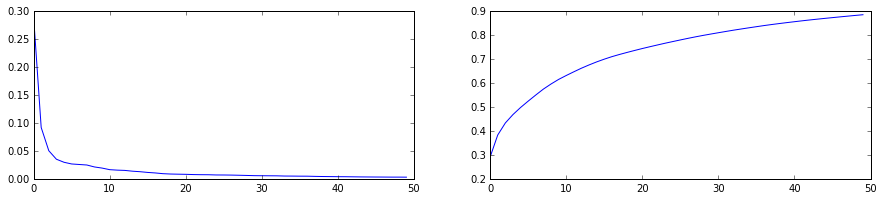

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 50).fit(log(1+x_train))
print(sum(pca.explained_variance_ratio_))
_ = figure(figsize = (15, 3))
_ = subplot(1, 2, 1)
_ =plot(pca.explained_variance_ratio_)
_ = subplot(1, 2, 2)
_ =plot(cumsum(pca.explained_variance_ratio_))

Первая компонента, видимо, просто отражает то, как много человек вообще транзачит.

Остальные отражают разные контрасты.

(20, 261)


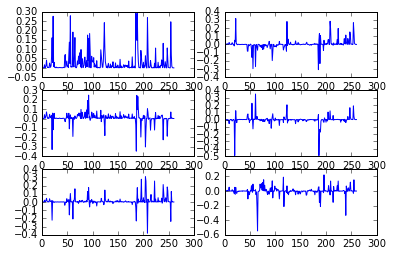

In [78]:
print(pca.components_.shape)
for i in range(6):
    subplot(3, 2, i+1)
    plot(pca.components_[i])

In [102]:
x_train_pca = pd.DataFrame(pca.transform(log(1+x_train)))
x_train_pca.index = x_train.index
x_train_pca.columns = ['pca_'+str(cn) for cn in x_train_pca.columns]
x_train_pca = pd.concat([log(1+x_train), x_train_pca], axis = 1)
x_train_pca.shape

(8400, 311)

In [107]:
x_test_pca = pd.DataFrame(pca.transform(log(1+x_test)))
x_test_pca.index = x_test.index
x_test_pca.columns = ['pca_'+str(cn) for cn in x_test_pca.columns]
x_test_pca = pd.concat([log(1+x_test), x_test_pca], axis = 1)
x_test_pca.shape

(3600, 311)

Градиентный бустинг, которому я добавил главных компонент, справляется хуже, чем без них.

глубина 5, шаг 0.1 - быстровато он обучается! Но замедление счастья не приносит; моя хренюшка справляется хуже логита.

Возможно, пихать всюду главные компоненты - так себе идея.

Но зато мне ОЧЕНЬ хочется сделать что-то ядерное.

In [175]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.03, n_estimators=500, subsample=1.0
                                 , min_samples_leaf = 50, max_depth=5)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(x_train_pca, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test_pca)[:,1])

0.86107203124999998

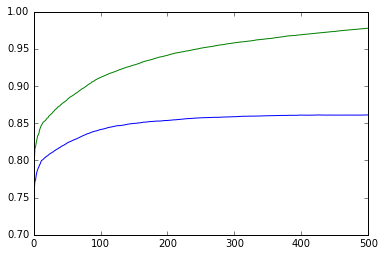

In [115]:
value_train= [roc_auc_score(y_train, pr) for pr in gbc.staged_decision_function(x_train_pca)]
value_test = [roc_auc_score(y_test,  pr) for pr in gbc.staged_decision_function(x_test_pca)]
plot(value_test)
plot(value_train)

Да, логит даёт уверенные 86.7%

In [116]:
lr = LogisticRegression(penalty= 'l2', C = 0.1, random_state = 42)
lr.fit(x_train_pca, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_pca)[:,1])

0.86702671875000004

### Надеваю бустинг на логит

А если надеть бустинг на логит?

Получаем джини меньше, чем от просто логита.

Если заставить бустинг меньше переобучаться, то побольше, до 86.9% (50 деревьев, шаг 0.1)

In [143]:
class init:
    def __init__(self, est):
        self.est = est
    def predict(self, X):
        pr = self.est.predict_proba(X)[:,1][:,numpy.newaxis]
        return log(pr/(1-pr))
    def fit(self, X, y, sample_weights):
        self.est.fit(X, y)

init_lr = init(LogisticRegression(penalty= 'l2', C = 0.1, random_state = 42))
        
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.03, n_estimators=200, subsample=1.0
                                 , min_samples_leaf = 500, max_depth=2, init = init_lr)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(x_train_pca, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test_pca)[:,1])

0.86973109375000002

Почему бустинг <b>портит</b> предсказание на тесте? Ну очевидно, потому что жестоко переобучаюсь.

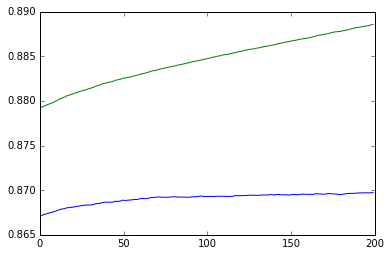

In [144]:
value_train= [roc_auc_score(y_train, pr) for pr in gbc.staged_decision_function(x_train_pca)]
value_test = [roc_auc_score(y_test,  pr) for pr in gbc.staged_decision_function(x_test_pca)]
plot(value_test)
plot(value_train)

Ага! А бустинг-то в основном на главные компоненты смотрит!

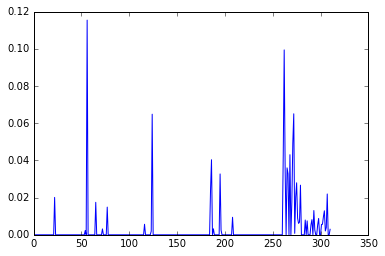

In [146]:
plot(gbc.feature_importances_)

логит же смотрит на всё подряд, но больше на MCC, чем на типы сделок.

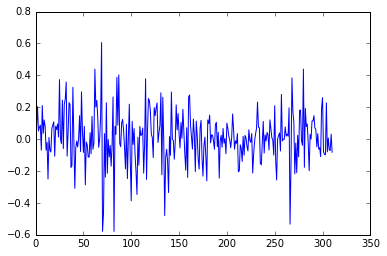

In [150]:
_ = plot(lr.coef_[0,:])

### Добавляю признаки по суммам транзакций

In [20]:
mcc_sums = transactions.groupby(['customer_id', 'mcc_code'])[['amount']].sum().reset_index()
mcc_sums = mcc_sums.pivot(index='customer_id', columns='mcc_code', values='amount').fillna(0)
mcc_sums.shape

(15000, 184)

In [21]:
type_sums = transactions.groupby(['customer_id', 'tr_type'])[['amount']].sum().reset_index()
type_sums = type_sums.pivot(index='customer_id', columns='tr_type', values='amount').fillna(0)
type_sums.shape

(15000, 77)

In [225]:
type_sums.shape

(15000, 77)

In [454]:
X = pd.concat([mcc_count, type_count, mcc_sums, type_sums], axis = 1)

Y_train = customers_gender.loc[X.index].gender
Y_train = Y_train.reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train.values[:, 0], test_size = 0.3, random_state = 42)

In [455]:
x_train.shape

(8400, 522)

Смотрим, как отрабатывает бустинг на признаках с суммой. Оказывается - хорошо!

In [456]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 50, max_depth=5)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(x_train, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test)[:,1])

0.86698468749999991

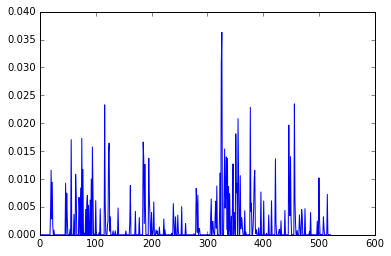

In [229]:
plot(gbc.feature_importances_)

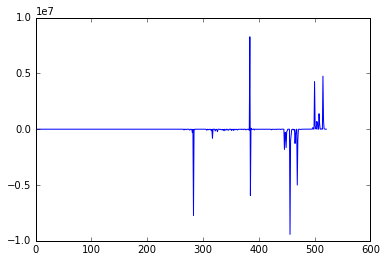

In [242]:
plot(x_train.mean(axis = 0).tolist())

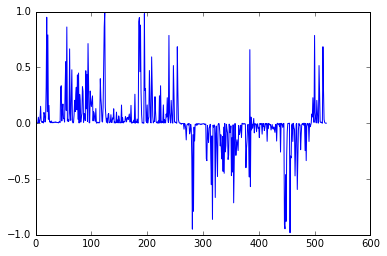

In [236]:
plot(mean(sign(x_train)).tolist())

In [458]:
x_train_log = sign(x_train) * log(1+abs(x_train))
x_test_log = sign(x_test) * log(1+abs(x_test))

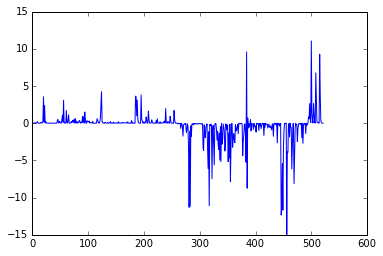

In [248]:
plot(x_train_log.mean(axis = 0).tolist())

Логит на логарифмированных широких признаках работает не сильно лучше, чем на узких

In [258]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train_log, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_log)[:,1])

0.86712843750000002

Нейронка чё-то вообще не тащит. Хотя это сильно зависит от масштабирования признаков!

In [296]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train_log)

Как ни странно, лучше всего пока отрабатывает нейронка всего из 3 клеток

In [335]:
nn2 = MLPClassifier(hidden_layer_sizes=(3), activation='logistic', alpha=0.1, early_stopping=True, random_state = 42)
nn2.fit(scaler.transform(x_train_log), y_train)
roc_auc_score(y_test,  nn2.predict_proba(scaler.transform(x_test_log))[:,1])

0.86809687499999999

Пытаюсь зарядить гауссовскую SVM. Увы, не очень проходит.

In [383]:
for gamma in [0.001, 0.003, 0.01, 0.03, 0.1]:
    for C in [0.1, 1, 10]:
        svc = SVC(C=C, kernel='rbf', degree=3, gamma=gamma, random_state=42)
        svc.fit(scaler.transform(x_train_log), y_train)
        print(C, gamma, roc_auc_score(y_test,  svc.decision_function(scaler.transform(x_test_log))))

0.1 0.001 0.8073896875
1 0.001 0.856276875
10 0.001 0.846948125
0.1 0.003 0.774306875
1 0.003 0.8293546875
10 0.003 0.8076421875
0.1 0.01 0.7521946875
1 0.01 0.770443125
10 0.01 0.7512828125
0.1 0.03 0.701570625
1 0.03 0.711588125
10 0.03 0.69868984375
0.1 0.1 0.631938125
1 0.1 0.62718703125
10 0.1 0.62169515625


#### Выкидываю лишние фичи

In [459]:
x_train_log_sparse = x_train_log.copy()
x_test_log_sparse = x_test_log.copy()


In [461]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 50, max_depth=5)
gbc.fit(x_train_log_sparse, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test_log_sparse)[:,1])

0.86705062499999996

In [468]:
mean(gbc.feature_importances_>0)

0.32758620689655171

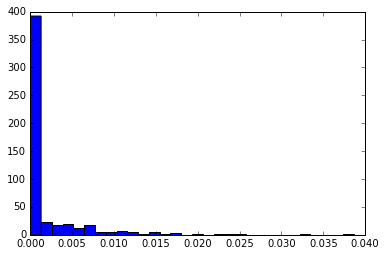

In [463]:
_ = hist(gbc.feature_importances_, bins = 30)

Ага! За счёт отбора признаков логрегрессия работает лучшеее!

In [466]:
important = x_train_log.columns[gbc.feature_importances_>0]
x_train_log_sparse = x_train_log_sparse[important]
x_test_log_sparse = x_test_log_sparse[important]

In [467]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train_log_sparse, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_log_sparse)[:,1])

0.8683609375000001

In [484]:
mean(gbc.feature_importances_>0.003)

0.19348659003831417

In [483]:
important = x_train_log.columns[gbc.feature_importances_>0.003]
x_train_log_sparse = x_train_log[important]
x_test_log_sparse = x_test_log[important]
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train_log_sparse, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_log_sparse)[:,1])

0.86559843749999998

Кажется, теперь я достиг новых высот Oo

In [499]:
roc_auc_score(y_test,  gbc.predict_proba(x_test_log)[:,1]+lr.predict_proba(x_test_log_sparse)[:,1])

0.87368531250000003

In [498]:
scaler= StandardScaler().fit(x_train_log_sparse)
nn2 = MLPClassifier(hidden_layer_sizes=(100), activation='logistic', alpha=0.1, early_stopping=True, random_state = 42)
nn2.fit(scaler.transform(x_train_log_sparse), y_train)
roc_auc_score(y_test,  nn2.predict_proba(scaler.transform(x_test_log_sparse))[:,1])

0.8592815625000001

#### Фиксирую успех: модель на предотобранных фичах, AUC 87.3%

In [509]:
X = pd.concat([mcc_count, type_count, mcc_sums, type_sums], axis = 1)

Y_train = customers_gender.loc[X.index].gender
Y_train = Y_train.reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')

Y_train = Y_train.values[:, 0]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

x_train_log = sign(x_train) * log(1+abs(x_train))
x_test_log = sign(x_test) * log(1+abs(x_test))
X_train_log = sign(X_train) * log(1+abs(X_train))

In [504]:
X_test = X.drop(customers_gender.index)
X_test_log = sign(X_test) * log(1+abs(X_test))

result = pd.DataFrame(X_test.index, columns=['customer_id'])


In [510]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 50, max_depth=5)
gbc.fit(X_train_log, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [511]:
important = X_train_log.columns[gbc.feature_importances_>0.003]
X_train_log_sparse = X_train_log[important]
X_test_log_sparse = X_test_log[important]
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(X_train_log_sparse, Y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
result['gender'] = gbc.predict_proba(X_test_log)[:, 1]*0.5 + lr.predict_proba(X_test_log_sparse)[:, 1]*0.5
result.to_csv('a07.csv', index=False)
result.head()

#### а если я всё просто бинаризую?

In [350]:
X = pd.concat([mcc_count>0, type_count>0], axis = 1)

Y_train = customers_gender.loc[X.index].gender
Y_train = Y_train.reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train.values[:, 0], test_size = 0.3, random_state = 42)

На бинаризованных признаках и логит, и бустинг не дотягивают

In [352]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test)[:,1])

0.84133765625000001

In [366]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 100, max_depth=5)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(x_train, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test)[:,1])

0.83194906249999989

In [371]:
rf = RandomForestClassifier(random_state = 42, n_estimators = 1000, min_samples_leaf = 50)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
rf.fit(x_train, y_train)
roc_auc_score(y_test,  rf.predict_proba(x_test)[:,1])

0.81164640624999995

Таки никто не остановит мою мечту запустить SVM!

Только SVM сука не тянет. Отрабатывает хуже логита!

In [375]:
from sklearn.svm import SVC
svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', random_state=42)
svc.fit(x_train, y_train)
roc_auc_score(y_test,  svc.decision_function(x_test))

0.83338609374999995

In [379]:
for gamma in [0.001, 0.01, 0.1, 1, 10]:
    for C in [0.1, 1, 10]:
        svc = SVC(C=C, kernel='rbf', degree=3, gamma=gamma, random_state=42)
        svc.fit(x_train, y_train)
        print(C, gamma, roc_auc_score(y_test,  svc.decision_function(x_test)))

0.1 0.001 0.76845890625
1 0.001 0.82039140625
10 0.001 0.83795171875
0.1 0.01 0.81403890625
1 0.01 0.83749890625
10 0.01 0.83527984375
0.1 0.1 0.78875546875
1 0.1 0.82079234375
10 0.1 0.79805859375
0.1 1 0.64592609375
1 1 0.65061296875
10 1 0.64542390625
0.1 10 0.5037396875
1 10 0.50515828125
10 10 0.505491875


In [380]:
svc = SVC(C=10, kernel='rbf', degree=3, gamma=0.0001, random_state=42)
svc.fit(x_train, y_train)
roc_auc_score(y_test,  svc.decision_function(x_test))

0.82100203124999993

Пробую запуститься и на ДОЛЯХ (к обороту)

In [445]:
mcc_shares = (mcc_sums.abs().transpose() / mcc_sums.abs().sum(axis = 1)).transpose()
type_shares = (type_sums.abs().transpose() / type_sums.abs().sum(axis = 1)).transpose()

In [446]:
X = pd.concat([mcc_count, type_count, mcc_shares, type_shares], axis = 1)

Y_train = customers_gender.loc[X.index].gender
Y_train = Y_train.reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train.values[:, 0], test_size = 0.3, random_state = 42)

x_train_log = sign(x_train) * log(1+abs(x_train))
x_test_log = sign(x_test) * log(1+abs(x_test))

Если запуститься на долях, падаю с ошибкой - ибо есть люди с отрицательными долями, т.к. отрицательная сумма транзакций. Что ж, беру всё по модулю.

Но таки до модели на суммах моя модель не дотягивает.

In [448]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train_log, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_log)[:,1])

0.86463640625000004

In [449]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 100, max_depth=5)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(x_train_log, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test_log)[:,1])

0.86074593749999995

In [453]:
roc_auc_score(y_test,  lr.predict_proba(x_test_log)[:,1]*0.5+gbc.predict_proba(x_test_log)[:,1]*0.5)

0.87021109375000005

### В качестве фич можно ещё юзать минимумы и максимумы

In [518]:
mcc_maxs = transactions.groupby(['customer_id', 'mcc_code'])[['abs_amount']].max().reset_index()
mcc_maxs = mcc_maxs.pivot(index='customer_id', columns='mcc_code', values='abs_amount').fillna(0)
mcc_maxs.shape

(15000, 184)

In [520]:
type_maxs = transactions.groupby(['customer_id', 'tr_type'])[['abs_amount']].max().reset_index()
type_maxs = type_maxs.pivot(index='customer_id', columns='tr_type', values='abs_amount').fillna(0)
type_maxs.shape

(15000, 77)

In [723]:
X = pd.concat([mcc_count, type_count, mcc_sums, type_sums, mcc_shares, type_shares, mcc_maxs, type_maxs], axis = 1)

Y_train = customers_gender.loc[X.index].gender
Y_train = Y_train.reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train.values[:, 0], test_size = 0.3, random_state = 42)

Y_train = Y_train.values[:, 0]

x_train_log = sign(x_train) * log(1+abs(x_train))
x_test_log = sign(x_test) * log(1+abs(x_test))

Добавляю отмасштабированных фич

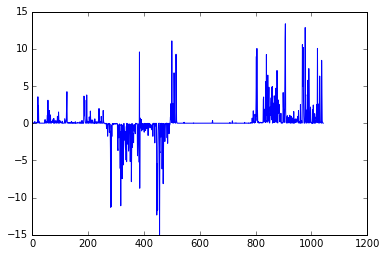

In [528]:
plot(x_train_log.mean().tolist())

In [724]:
scaler = StandardScaler().fit(x_train_log)
x_train_log_sc = scaler.transform(x_train_log)
x_test_log_sc = scaler.transform(x_test_log)

Главные компоненты не очень помогают, но что-то да они объясняют.

0.52745826647


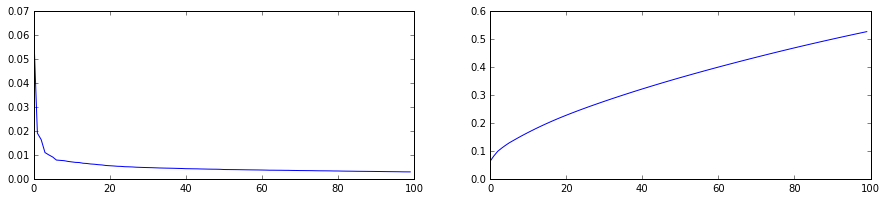

In [725]:
pca = PCA(n_components = 100, random_state = 42)
pca.fit(x_train_log_sc)
print(sum(pca.explained_variance_ratio_))
_ = figure(figsize = (15, 3))
_ = subplot(1, 2, 1)
_ =plot(pca.explained_variance_ratio_)
_ = subplot(1, 2, 2)
_ =plot(cumsum(pca.explained_variance_ratio_))

In [549]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 100, max_depth=5)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(x_train_log, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test_log)[:,1])

0.86462093750000002

Важнее всего всё равно суммы!

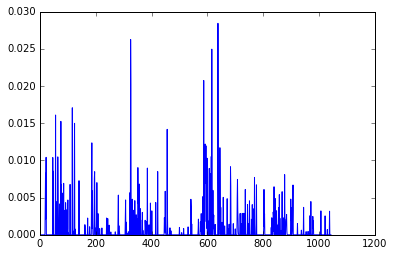

In [550]:
plot(gbc.feature_importances_)

In [551]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train_log_sc, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_log_sc)[:,1])

0.86140968749999991

Ежели мы добавляем главные компоненты в признаки, 

In [726]:
x_train_log_sc_pca = np.concatenate([x_train_log_sc, pca.transform(x_train_log_sc)], axis = 1)
x_test_log_sc_pca = np.concatenate([x_test_log_sc, pca.transform(x_test_log_sc)], axis = 1)
x_train_log_sc_pca.shape

(8400, 1144)

Бустинг неплохо так взлетает, на полпроцента, при добавлении главных компонент; он им придаёт неплохие важности.

логиту не горячно не холодно

In [559]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 100, max_depth=5)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(x_train_log_sc_pca, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test_log_sc_pca)[:,1])

0.86981140625000009

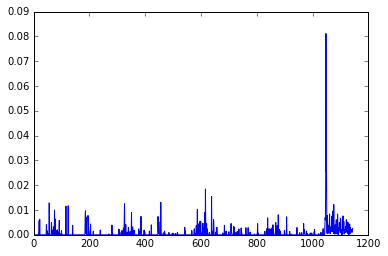

In [561]:
plot(gbc.feature_importances_)

Нейронка справляется так себе (86.6 максимум с 50 нейронами)

In [749]:
nn = MLPClassifier(hidden_layer_sizes=(50,20), activation='logistic', alpha=0.01, early_stopping=True, random_state = 42)
nn.fit(x_train_log_sc_pca, y_train)
roc_auc_score(y_test,  nn.predict_proba(x_test_log_sc_pca)[:,1])

0.86146124999999996

In [558]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train_log_sc_pca, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_log_sc_pca)[:,1])

0.86142187499999989

Лес существенно уступает нормальным алгоритмам

In [563]:
rf = RandomForestClassifier(n_estimators = 1000, min_samples_leaf = 10, random_state = 42)
rf.fit(x_train_log_sc_pca, y_train)
roc_auc_score(y_test,  rf.predict_proba(x_test_log_sc_pca)[:,1])

0.84755500000000006

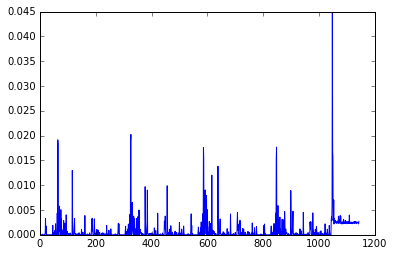

In [567]:
plot(rf.feature_importances_)

In [575]:
ths = [0, 0.0001, 0.001, 0.002, 0.003, 0.005, 0.01, 0.03]
for th in ths:
    print(th, mean(rf.feature_importances_ > th ))

0 0.638986013986
0.0001 0.407342657343
0.001 0.225524475524
0.002 0.16520979021
0.003 0.0646853146853
0.005 0.0244755244755
0.01 0.0122377622378
0.03 0.000874125874126


Проверяю, как обрубание по лесу влияет на качество. Оказалось, лучше всего иметь фичи начиная с 1/1000 (22% от всех)

In [576]:
for th in ths:
    lr.fit(x_train_log_sc_pca[:, rf.feature_importances_ > th], y_train)
    print(th, roc_auc_score(y_test,  lr.predict_proba(x_test_log_sc_pca[:, rf.feature_importances_ > th])[:,1]))

0 0.864796875
0.0001 0.867923125
0.001 0.8679575
0.002 0.866339375
0.003 0.8530790625
0.005 0.824833125
0.01 0.8054046875
0.03 0.7382928125


In [577]:
lr.fit(x_train_log_sc_pca[:, rf.feature_importances_ > 0.001], y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Ладно, попробуем отправить, что есть.

In [580]:
X_train_log = sign(X_train) * log(1+abs(X_train))
X_train_log_sc = scaler.transform(X_train_log)
X_train_log_sc_pca = np.concatenate([X_train_log_sc, pca.transform(X_train_log_sc)], axis = 1)
X_train_log_sc_pca.shape

(12000, 1144)

In [579]:
X_test = X.drop(customers_gender.index)
X_test_log = sign(X_test) * log(1+abs(X_test))
X_test_log_sc = scaler.transform(X_test_log)
X_test_log_sc_pca = np.concatenate([X_test_log_sc, pca.transform(X_test_log_sc)], axis = 1)
X_test_log_sc_pca.shape

(3000, 1144)

In [585]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 100, max_depth=5)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(X_train_log_sc_pca, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [587]:
result['gender'] = gbc.predict_proba(X_test_log_sc_pca)[:, 1]
result.to_csv('a08.csv', index=False)
result.head()

,customer_id,gender
0,49101,0.278234
1,114348,0.743923
2,127946,0.686719
3,137367,0.661188
4,174467,0.713999


In [589]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(X_train_log_sc_pca[:, rf.feature_importances_ > 0.001], Y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [590]:
result['gender'] = lr.predict_proba(X_test_log_sc_pca[:, rf.feature_importances_ > 0.001])[:, 1]
result.to_csv('a09.csv', index=False)

И все решения абсолютно провальные на валидации! Писец какой-то

In [591]:
result['gender'] = (lr.predict_proba(X_test_log_sc_pca[:, rf.feature_importances_ > 0.001])[:, 1] * 0.5 
                    + gbc.predict_proba(X_test_log_sc_pca)[:, 1] * 0.5)
result.to_csv('a10.csv', index=False)

#### работа над ошибками

In [593]:
lr.fit(x_train_log_sc_pca[:, rf.feature_importances_ > 0.001], y_train)
pr = lr.predict_proba(x_test_log_sc_pca[:, rf.feature_importances_ > 0.001])[:,1]

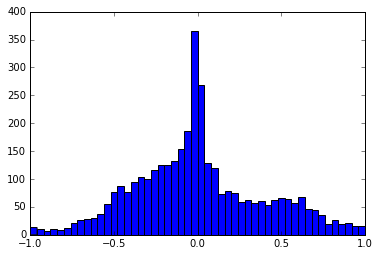

In [598]:
resid = y_test-pr
_ = hist(resid, bins = 50)

In [628]:
err1, err2 = x_test.index[resid >=0.99], x_test.index[resid <= -0.99]
err1.tolist(), err2.tolist()

([44349687, 82244228, 10789064, 13799180], [20795048, 82776368, 15053840])

In [642]:
#err_table = pd.merge(transactions, pd.DataFrame({'customer_id':err1.tolist()})).transpose()
x1 = transactions[transactions.customer_id == 13799180]
x1.shape

(430, 8)

Один мужик только и транзачил, что 4784 - дорожное и мостовое. Непонятно, чё его в бабы записали.
Другие действительно ходили во всякие магазины женской одежды.

Одна женщина, принятая за мужика, засветилась в службах знакомств; одна транзачила много и непонятно; одна много возилась с оборудованием.

In [643]:
pd.merge(x1, tr_mcc_codes) #.groupby('mcc_description')[['amount']].count()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,time,abs_amount,mcc_description
0,13799180,1 00:00:00,4121,1200,-68046.08,NaN,0,68046.08,Лимузины и такси
1,13799180,1 16:26:38,5661,1110,-146635.84,NaN,16,146635.84,Обувные магазины
2,13799180,8 18:45:02,5661,1210,-93676.02,NaN,18,93676.02,Обувные магазины
3,13799180,78 19:00:13,5661,1110,-1186517.30,NaN,19,1186517.30,Обувные магазины
4,13799180,94 17:19:23,5661,1210,-311436.87,NaN,17,311436.87,Обувные магазины
5,13799180,101 20:45:35,5661,1110,-212957.73,NaN,20,212957.73,Обувные магазины
6,13799180,113 19:17:59,5661,1110,-396179.54,NaN,19,396179.54,Обувные магазины
7,13799180,246 00:00:00,5661,1110,-188656.92,15342089,0,188656.92,Обувные магазины
8,13799180,296 13:04:08,5661,1110,-230453.42,29065120,13,230453.42,Обувные магазины
9,13799180,386 00:00:00,5661,1110,-253788.48,29218421,0,253788.48,Обувные магазины


#### 

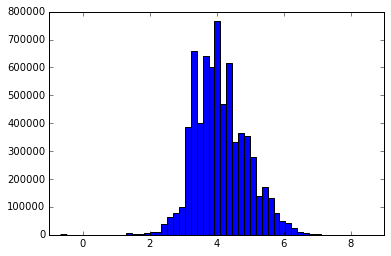

In [647]:
_ = hist(log10(transactions.abs_amount), bins = 50)

tf idf

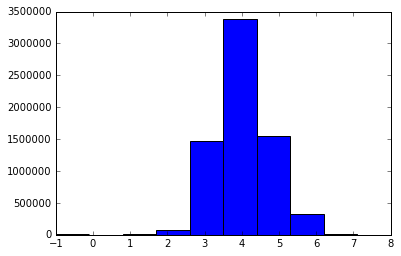

In [653]:
_ = hist(round(log10(transactions.abs_amount)))

In [25]:
vol = round(log10(transactions.abs_amount))
vol[vol<2] = 2
vol[vol>6] = 6
transactions['l10_amt'] = vol

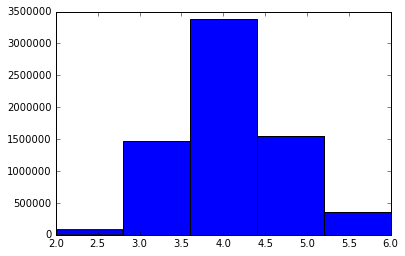

In [661]:
_ = hist(transactions['l10_amt'], bins = 5)

In [26]:
transactions['mcc_amt']=transactions['mcc_code']*100+transactions['l10_amt']

In [27]:
mccamt_cnt = transactions.groupby(['customer_id', 'mcc_amt'])[['amount']].count().reset_index()
mccamt_cnt = mccamt_cnt.pivot(index='customer_id', columns='mcc_amt', values='amount').fillna(0)
mccamt_cnt.shape

(15000, 833)

In [28]:
transactions['type_amt']=transactions['tr_type']*100+transactions['l10_amt']
typeamt_cnt = transactions.groupby(['customer_id', 'type_amt'])[['amount']].count().reset_index()
typeamt_cnt = typeamt_cnt.pivot(index='customer_id', columns='type_amt', values='amount').fillna(0)
typeamt_cnt.shape

(15000, 312)

In [23]:
X = pd.concat([mcc_count, type_count, mccamt_cnt], axis = 1)

Y_train = customers_gender.loc[X.index].gender
Y_train = Y_train.reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train.values[:, 0], test_size = 0.3, random_state = 42)

Y_train = Y_train.values[:, 0]

x_train_log = sign(x_train) * log(1+abs(x_train))
x_test_log = sign(x_test) * log(1+abs(x_test))

X_test = X.drop(customers_gender.index)
X_test_log = sign(X_test) * log(1+abs(X_test))

X_train_log = sign(X_train) * log(1+abs(X_train))
X_test_log = sign(X_test) * log(1+abs(X_test))

NameError: name 'customers_gender' is not defined

Ура! На признаках $mcc \times volume$ AUC выросла за 87.6%!

In [692]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train_log, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_log)[:,1])

0.87668875000000002

Бустинг тоже вышагивает за 87.7% уверенно.

глубина 4 - 87.29

глубина 5 - 87.72 (100 лист), 87.59 (300 лист), 87.22 (30 лист)

глубина 6 - 87.55

In [693]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=200, subsample=1.0
                                 , min_samples_leaf = 100, max_depth=5)
#cross_val_score(gbc, X_train, Y_train.values[:, 0], cv=3, scoring = 'roc_auc', n_jobs =3).mean()
gbc.fit(x_train_log, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test_log)[:,1])

0.87722234374999997

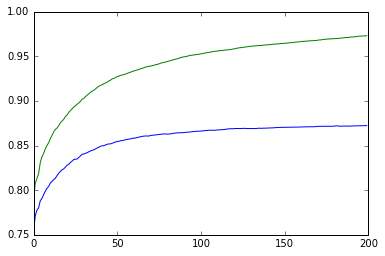

In [680]:
value_train= [roc_auc_score(y_train, pr) for pr in gbc.staged_decision_function(x_train_log)]
value_test = [roc_auc_score(y_test,  pr) for pr in gbc.staged_decision_function(x_test_log)]
plot(value_test)
plot(value_train)

Вместе мы впервые переваливаем за 88%!

In [694]:
roc_auc_score(y_test,  gbc.predict_proba(x_test_log)[:,1]+lr.predict_proba(x_test_log)[:,1])

0.88355874999999995

In [695]:
result = pd.DataFrame(X_test.index, columns=['customer_id'])
result['gender'] = lr.predict_proba(X_test_log)[:, 1]*0.5 + gbc.predict_proba(X_test_log)[:, 1]*0.5
result.to_csv('a12.csv', index=False)

Что ж, закачаем это на сервер, и раскачаем этот мир!

In [689]:
lr.fit(X_train_log, Y_train)
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=200, subsample=1.0
                                 , min_samples_leaf = 100, max_depth=5)
gbc.fit(X_train_log, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [690]:
result = pd.DataFrame(X_test.index, columns=['customer_id'])
result['gender'] = lr.predict_proba(X_test_log)[:, 1]*0.5 + gbc.predict_proba(X_test_log)[:, 1]*0.5
result.to_csv('a11.csv', index=False)

ах, так! ну давайте нейронку вместо логита

(150,50,5), relu, 0.01 - 0.877

(150,100,5), relu, 0.01 = 87.82

(150,100,20), relu, 0.01 = 87.93

(150,100,20), relu, 0.03 = 87.88

(150,100,20), relu, 0.003 = 87.83

In [714]:
nn = MLPClassifier(hidden_layer_sizes=(150,100,20), activation='relu', alpha=0.01, early_stopping=True, random_state = 42)
nn.fit(x_train_log, y_train)
roc_auc_score(y_test,  nn.predict_proba(x_test_log)[:,1])

0.87936031250000002

Почему-то нейронка очень нравится этой херне, и с нейронкой лучше, чем без неё.

In [715]:
result = pd.DataFrame(X_test.index, columns=['customer_id'])
result['gender'] = nn.predict_proba(X_test_log)[:, 1]*0.5 + gbc.predict_proba(X_test_log)[:, 1]*0.5
result.to_csv('a12.csv', index=False)

TF-IDF отрабатывает ХУЁВО

In [721]:
from sklearn.feature_extraction.text import TfidfTransformer
idf = TfidfTransformer().fit(x_train)
x_train_idf = idf.transform(x_train)
x_test_idf = idf.transform(x_test)

In [722]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train_idf, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_idf)[:,1])

0.72318937500000002

### Ещё больше признаков, и ансамбль нейронок.

In [29]:
X = pd.concat([mcc_count, type_count, mcc_sums, type_sums, mccamt_cnt, typeamt_cnt, time_count], axis = 1)
X.shape

(15000, 1691)

In [36]:
#X = pd.concat([mcc_count, type_count, mcc_sums, type_sums, mccamt_cnt, typeamt_cnt, time_count], axis = 1)

Y_train = customers_gender.loc[X.index].reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train.values[:, 0], test_size = 0.3, random_state = 42)

Y_train = Y_train.values[:, 0]

x_train_log = sign(x_train) * log(1+abs(x_train))
x_test_log = sign(x_test) * log(1+abs(x_test))

X_test = X.drop(customers_gender.index)
X_test_log = sign(X_test) * log(1+abs(X_test))

X_train_log = sign(X_train) * log(1+abs(X_train))
X_test_log = sign(X_test) * log(1+abs(X_test))
X_train_log.shape

(12000, 1691)

ЛОгит выдаёт 88.2% точности, но вы ему не верьте!

In [37]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
lr.fit(x_train_log, y_train)
roc_auc_score(y_test,  lr.predict_proba(x_test_log)[:,1])

0.88205687499999996

Мешок логитов даёт

In [51]:
from sklearn.ensemble import BaggingClassifier
bag_lr = BaggingClassifier(base_estimator=lr, n_estimators=10, max_samples=1.0, max_features=1.0
                           , bootstrap=True, bootstrap_features=False, n_jobs=3, random_state = 42)
bag_lr.fit(x_train_log, y_train)
roc_auc_score(y_test,  bag_lr.predict_proba(x_test_log)[:,1])

0.8817387499999999

Нейронка выдаёт 88.2% точности

In [45]:
nn = MLPClassifier(hidden_layer_sizes=(100,10), activation='relu', alpha=0.01, early_stopping=True, random_state = 42)
nn.fit(x_train_log, y_train)
roc_auc_score(y_test,  nn.predict_proba(x_test_log)[:,1])

0.88219625000000002

10 таких нейронок дают 88.0% точности

In [48]:
from sklearn.ensemble import BaggingClassifier
bag_nn = BaggingClassifier(base_estimator=nn, n_estimators=10, max_samples=1.0, max_features=1.0
                           , bootstrap=True, bootstrap_features=False, n_jobs=3, random_state = 42)
bag_nn.fit(x_train_log, y_train)
roc_auc_score(y_test,  bag_nn.predict_proba(x_test_log)[:,1])

0.88038062500000014

Градиентный бустинг даёт 87.3%

In [47]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 50, max_depth=5)
gbc.fit(x_train_log, y_train)
roc_auc_score(y_test,  gbc.predict_proba(x_test_log)[:,1])

0.87308578125000003

Мешок бустингов даёт 

In [49]:
from sklearn.ensemble import BaggingClassifier
bag_gb = BaggingClassifier(base_estimator=gbc, n_estimators=10, max_samples=1.0, max_features=1.0
                           , bootstrap=True, bootstrap_features=False, n_jobs=3, random_state = 42)
bag_gb.fit(x_train_log, y_train)
roc_auc_score(y_test,  bag_gb.predict_proba(x_test_log)[:,1])

0.87500812500000014

Сумма двух мешков даёт

In [50]:
roc_auc_score(y_test,  bag_gb.predict_proba(x_test_log)[:,1]+bag_nn.predict_proba(x_test_log)[:,1])

0.88554937500000008

Сумма трёх мешков даёт

In [52]:
roc_auc_score(y_test,  bag_gb.predict_proba(x_test_log)[:,1]
              +bag_nn.predict_proba(x_test_log)[:,1] +bag_lr.predict_proba(x_test_log)[:,1])

0.88709187500000009

In [56]:
result = pd.DataFrame(X_test.index, columns=['customer_id'])
result['gender'] = (bag_nn.predict_proba(X_test_log)[:, 1]*0.33 
                    + gbc.predict_proba(X_test_log)[:, 1]*0.34
                    +bag_lr.predict_proba(X_test_log)[:,1]*0.33 )
result.to_csv('a13.csv', index=False)

И снова получаю хуйню

## Психанул

### Ещё один вариант: много разных нейронок; старый набор признаков.

In [57]:
X = pd.concat([mcc_count, type_count, mcc_sums, type_sums,time_count], axis = 1)
X.shape

(15000, 546)

In [58]:
#X = pd.concat([mcc_count, type_count, mcc_sums, type_sums, mccamt_cnt, typeamt_cnt, time_count], axis = 1)

Y_train = customers_gender.loc[X.index].reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)

X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train.values[:, 0], test_size = 0.3, random_state = 42)

Y_train = Y_train.values[:, 0]

x_train_log = sign(x_train) * log(1+abs(x_train))
x_test_log = sign(x_test) * log(1+abs(x_test))

X_test = X.drop(customers_gender.index)
X_test_log = sign(X_test) * log(1+abs(X_test))

X_train_log = sign(X_train) * log(1+abs(X_train))
X_test_log = sign(X_test) * log(1+abs(X_test))
X_train_log.shape

(12000, 546)

In [59]:
lr = LogisticRegression(penalty= 'l2', C = 0.01, random_state = 42)
bag_lr = BaggingClassifier(base_estimator=lr, n_estimators=100, max_samples=1.0, max_features=1.0
                           , bootstrap=True, bootstrap_features=False, n_jobs=3, random_state = 42)
bag_lr.fit(X_train_log, Y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=3, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [60]:
gbc = GradientBoostingClassifier(random_state = 42, learning_rate=0.1, n_estimators=100, subsample=1.0
                                 , min_samples_leaf = 50, max_depth=5)
bag_gb = BaggingClassifier(base_estimator=gbc, n_estimators=30, max_samples=1.0, max_features=1.0
                           , bootstrap=True, bootstrap_features=False, n_jobs=3, random_state = 42)
bag_gb.fit(X_train_log, Y_train)

BaggingClassifier(base_estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=30, n_jobs=3, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [61]:
nn = MLPClassifier(hidden_layer_sizes=(150,50,5), activation='relu', alpha=0.01, early_stopping=True, random_state = 42)
bag_nn = BaggingClassifier(base_estimator=nn, n_estimators=30, max_samples=1.0, max_features=1.0
                           , bootstrap=True, bootstrap_features=False, n_jobs=3, random_state = 42)
bag_nn.fit(X_train_log, Y_train)

BaggingClassifier(base_estimator=MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(150, 50, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=30, n_jobs=3, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

Аккуратно расставляю веса, и делаю финальное предсказание.

In [63]:
result = pd.DataFrame(X_test.index, columns=['customer_id'])
result['gender'] = (bag_nn.predict_proba(X_test_log)[:, 1]*0.30 
                    + bag_gb.predict_proba(X_test_log)[:, 1]*0.40
                    +bag_lr.predict_proba(X_test_log)[:,1]*0.30 )
result.to_csv('a14.csv', index=False)